### TO DO:
- check warnings
- impose composition after each trial
- configs for inputs??
- bayesian serach for beta?

In [5]:
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from compositional_metarl.task import MultiArmedBandit
from compositional_metarl.model import QDNDLSTM as Agent
from compositional_metarl.utils import compute_stats, to_sqnp
from compositional_metarl.model.DND import compute_similarities
from compositional_metarl.model.utils import get_reward, compute_returns, compute_a2c_loss, get_reward_mab, run_agent_inference, one_hot_embedding
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import torch.nn.functional as F
from compositional_metarl.trainers import Trainer, evaluate

sns.set(style='white', context='talk', palette='colorblind')
seed_val = 0 
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed(seed_val)

In [6]:
'''init task'''

start_arm = 0
end_arm = 7
n_arms = (end_arm - start_arm) + 1
n_rounds = 50 # per function
n_trials = 10
normalize_rewards = True
noise_per_arm = None #'per_arm'
cue_per_epoch = True
# CUES =  {'periodic': torch.tensor([0.0, 1.0]), 'linear': torch.tensor([1.0, 0.0])} # 'linperiodic': torch.tensor([1.0, 1.0])} 
# CUES =  {'linear': torch.tensor(np.random.rand((2)))} #, 'linear': torch.tensor(np.random.rand((2)))} 'linperiodic': torch.tensor([1.0, 1.0])} 
# CUES =  {'linpos': [1., 0.],  'pereven': [0., 1.]}
CUES =  {'linpos': [1., 0.],  'pereven': [0., 1.], 
         'linneg': [1., 1.],  'perodd':  [0., 0.]}
#CUES =  {'linear': [1., 0.],  'periodic': [0., 1.], 'linperiodic': [1., 1.]}
n_cues = len(CUES)
ctx_dim = len(CUES['linpos'])
aoi = {'linpos': 7, 'pereven': 6, # }
       'linneg': 0,'perodd': 7}   # np.random.choice([0, 2, 4, 6])

In [7]:
task = MultiArmedBandit(cues=CUES, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds, 
                        normalize=normalize_rewards, noise_per_arm=noise_per_arm, cue_per_epoch=cue_per_epoch,
                        best_arms=aoi)

In [8]:
'''init model'''

# DNDLSTM params
dim_hidden = 48 #64
inp_dim = None
inputs = 'context_action_reward'
dim_output = n_arms
estimate_Qvals = True
dict_len = 1000
kernel = 'cosine' # 'l1' or 'l2'
dnd_policy = 'softmax' # 'softmax' or '1NN'
unique_keys = True
exclude_key = True

In [9]:
agent = Agent(dim_hidden, dim_output, dict_len, input_dim=inp_dim, ctx_dim=ctx_dim, inputs=inputs, kernel=kernel, dnd_policy=dnd_policy, unique_keys=unique_keys, q_est=estimate_Qvals)

In [10]:
'''init trainer'''

n_epochs = 1000
learning_rate = 1e-3 #5e-4 
gamma = 0.8 # 0.8
simulate_annealing = False
beta = .05 # weight for entropy loss
normalize_return = True
early_stopping = False
infer_composition = False

In [11]:
trainer = Trainer(agent, task, early_stopping=early_stopping, seed=seed_val, lr=learning_rate, n_trials=n_trials, beta=beta, 
                  gamma=gamma, normalize_return=normalize_return, simulate_annealing=simulate_annealing, infer_composition=infer_composition, n_epochs=n_epochs)

In [ ]:
'''train model'''
out, avg_train_loss, avg_cum_rewards, _ = trainer.train()
n_epochs = trainer.current_epoch + 1

Epoch 1 / 1000| cum. return = 0.51 | loss: val = 0.31, pol = 0.17, entropy = 2.04 | time = 8.91
Epoch 2 / 1000| cum. return = 0.57 | loss: val = 0.16, pol = 0.00, entropy = 2.01 | time = 8.46
Epoch 3 / 1000| cum. return = 0.56 | loss: val = 0.14, pol = 0.00, entropy = 1.96 | time = 8.53
Epoch 4 / 1000| cum. return = 0.50 | loss: val = 0.18, pol = 0.02, entropy = 1.99 | time = 8.49
Epoch 5 / 1000| cum. return = 0.54 | loss: val = 0.14, pol = -0.06, entropy = 1.87 | time = 9.02
Epoch 6 / 1000| cum. return = 0.75 | loss: val = 0.07, pol = -0.08, entropy = 1.53 | time = 8.86
Epoch 7 / 1000| cum. return = 0.54 | loss: val = 0.14, pol = 0.03, entropy = 1.61 | time = 8.98
Epoch 8 / 1000| cum. return = 0.78 | loss: val = 0.08, pol = -0.11, entropy = 1.40 | time = 8.59
Epoch 9 / 1000| cum. return = 0.50 | loss: val = 0.15, pol = 0.03, entropy = 1.79 | time = 8.72
Epoch 10 / 1000| cum. return = 0.55 | loss: val = 0.13, pol = -0.00, entropy = 1.88 | time = 8.53
Epoch 11 / 1000| cum. return = 0.78

n_epochs = 42

## save model

## figures

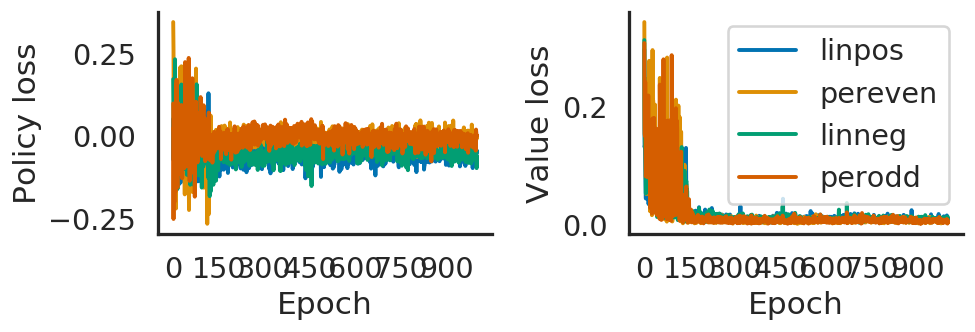

In [11]:
'''loss functions'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(trainer.log_loss_policy.mean(2)[:n_epochs])
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_ylabel('Policy loss')
axes[0].set_xlabel('Epoch')

axes[1].plot(trainer.log_loss_value.mean(2)[:n_epochs])
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Value loss')
axes[1].set_xlabel('Epoch')

plt.legend(CUES)
sns.despine()
f.tight_layout()

In [58]:
n_epochs=150

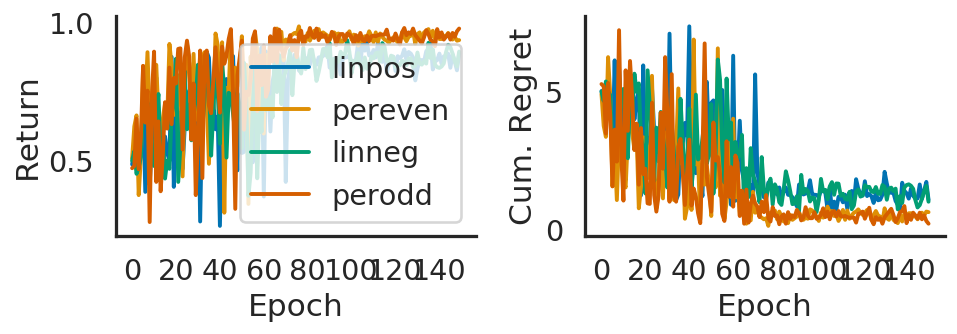

In [59]:
'''learning curves'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(trainer.log_cum_return.mean(2)[:n_epochs])
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[0].plot(np.repeat(log_Y[:, 0, :, 7].mean(1).mean(), n_epochs), '_k')

# axes[1].plot(log_regret.mean(3).mean(2)) # mean regreat across trials and rounds
axes[1].plot(trainer.log_regret.cumsum(3).max(3).mean(2)[:n_epochs])
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Cum. Regret')
axes[1].set_xlabel('Epoch')

axes[0].legend(CUES)
sns.despine()
f.tight_layout()

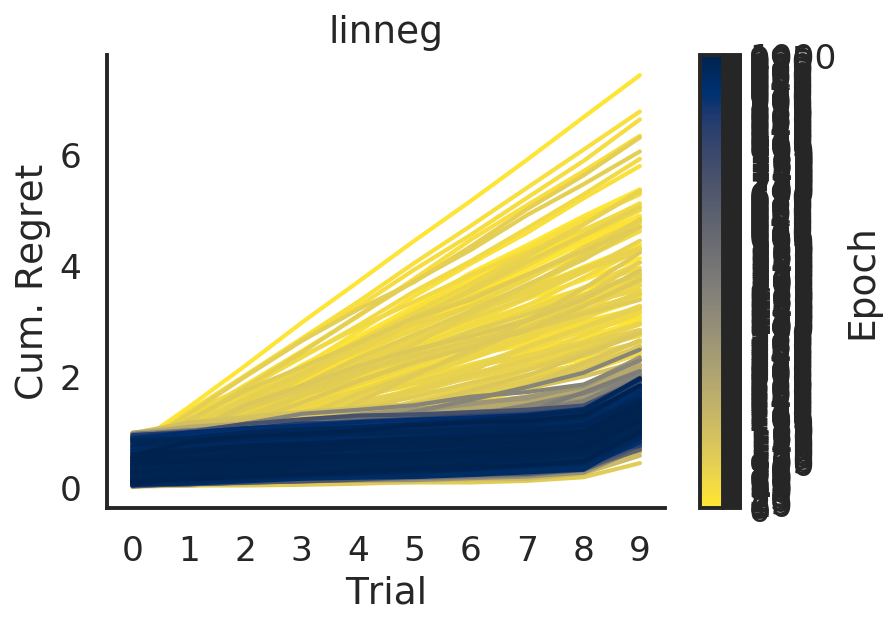

In [10]:
''' cumulative rewards across trials per epoch (averaged across episodes/rounds)'''

cue = 'linneg'

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx        
assert(cue_id is not None)

# set up the color scheme
c = np.arange(n_epochs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# configure figure
f, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
cum_regret = trainer.log_regret.cumsum(3)
for ep in range(n_epochs):
    ax.plot(cum_regret[ep,cue_id,:,:].T.mean(1), linewidth=2, c=cmap.to_rgba(ep + 1))
            
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlabel='Trial',
       ylabel='Cum. Regret',
       title=cue)
cbar = plt.colorbar(cmap, ticks=np.arange(n_epochs+1, step=5), ax=ax)
cbar.set_label('Epoch', rotation=90)
sns.despine()

for aa in ax.xaxis.get_major_ticks():
    aa.set_visible(True)

plt.show()

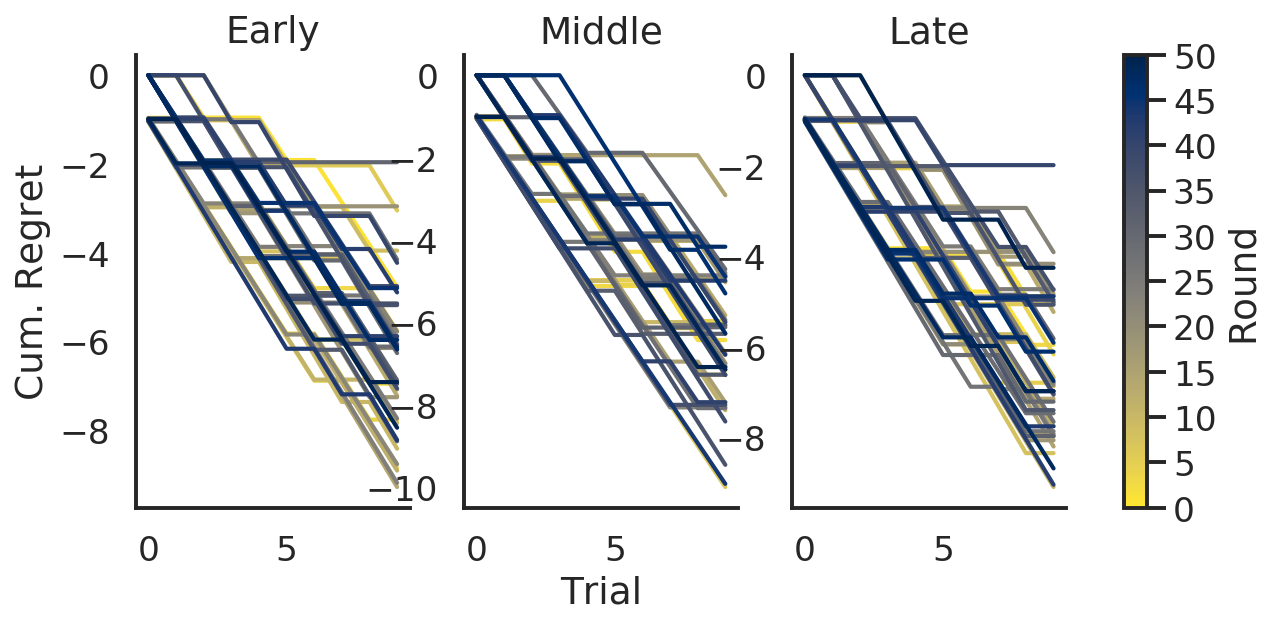

In [43]:
''' cumulative rewards across trials across rounds in early, middle, last epoch'''

cue = 'linear'
early_epoch = 0
middle_epoch = np.int(n_epochs/2)
late_epoch = (n_epochs - 1)

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx
assert(cue_id is not None)

# set up the color scheme
c = np.arange(n_rounds+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# configure figure
f, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=150)
cum_regret = trainer.log_regret.cumsum(3)
for rnd in range(n_rounds):
    ax[0].plot(cum_regret[early_epoch,cue_id, rnd,:].T, linewidth=2, c=cmap.to_rgba(rnd + 1))
    ax[1].plot(cum_regret[middle_epoch,cue_id, rnd,:].T, linewidth=2, c=cmap.to_rgba(rnd + 1))
    ax[2].plot(cum_regret[late_epoch,cue_id, rnd,:].T, linewidth=2, c=cmap.to_rgba(rnd + 1))
    
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set(ylabel='Cum. Regret', title='Early')
ax[1].set(xlabel='Trial', title='Middle')
ax[2].set(title='Late')

#plt.suptitle('test')
cbar = plt.colorbar(cmap, ticks=np.arange(n_epochs+1, step=5), ax=ax)
cbar.set_label('Round', rotation=90)
sns.despine()
plt.show()


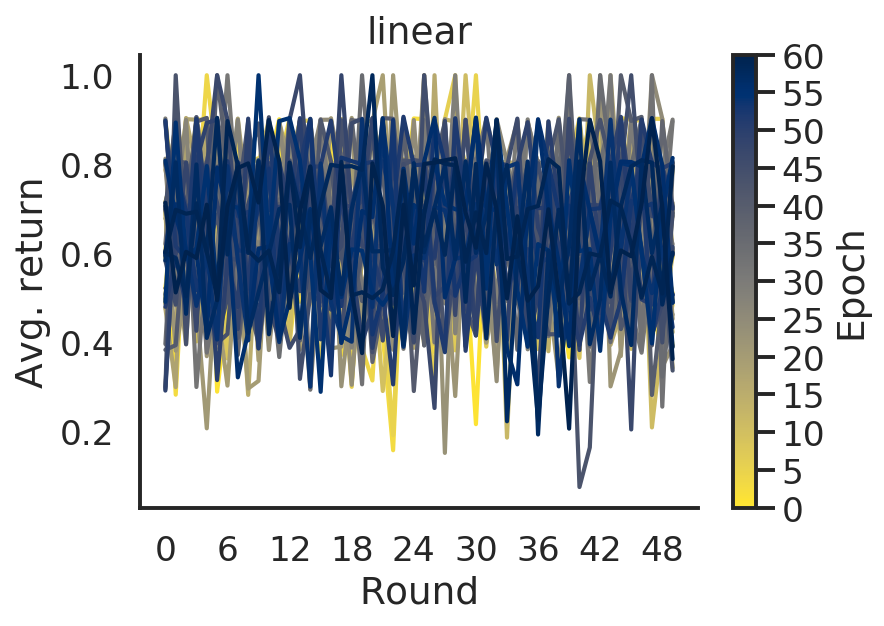

In [44]:
''' average rewards across rounds across epochs'''

cue = 'linear'

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx
assert(cue_id is not None)

# set up the color scheme
c = np.arange(n_epochs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# configure figure
f, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
for ep in range(n_epochs):
    ax.plot(trainer.log_cum_return[ep, cue_id], linewidth=2, c=cmap.to_rgba(ep + 1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlabel='Round',
       ylabel='Avg. return',
      title=cue)
cbar = plt.colorbar(cmap, ticks=np.arange(n_epochs+1, step=5), ax=ax)
cbar.set_label('Epoch', rotation=90)
sns.despine()
plt.show()

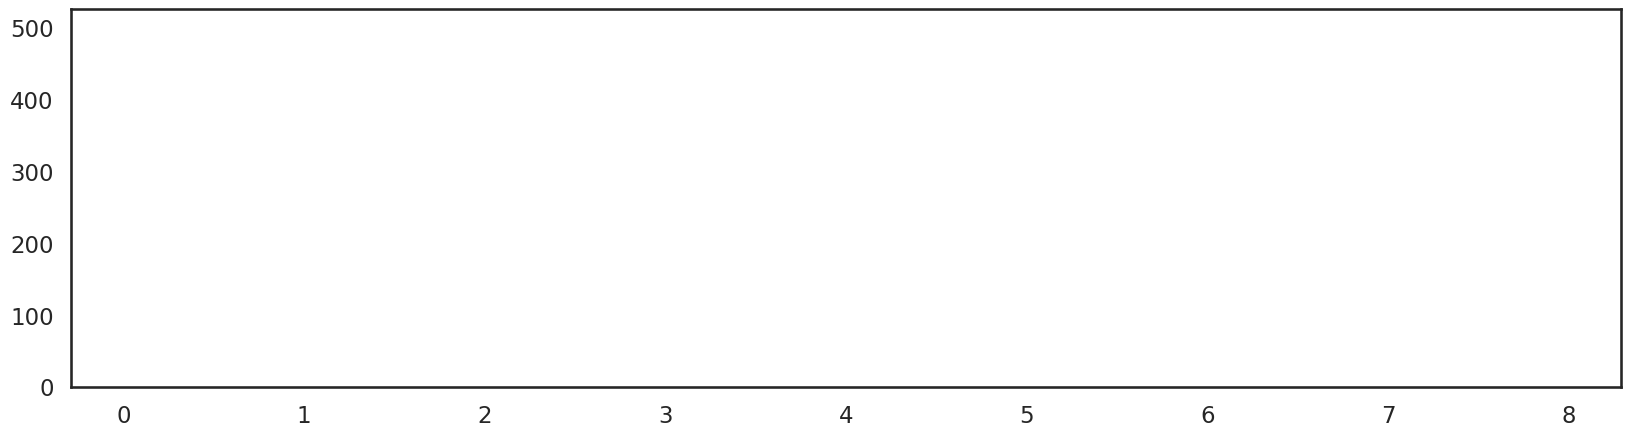

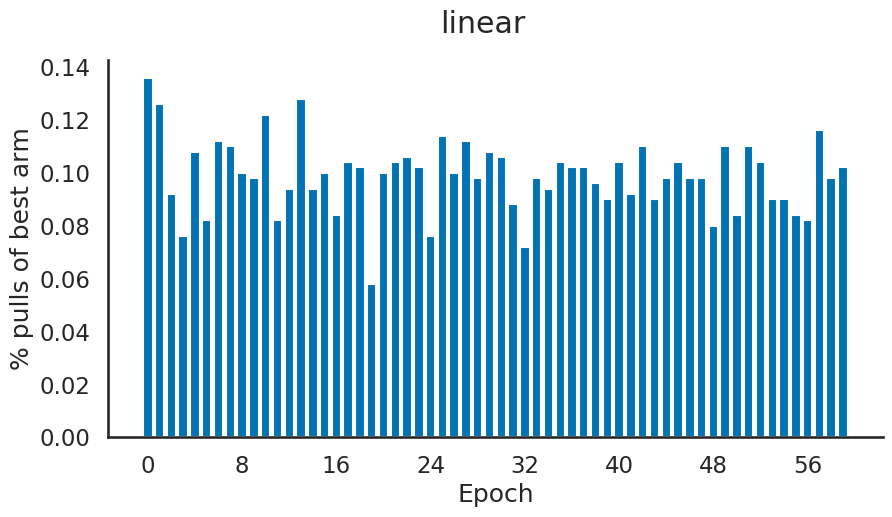

In [45]:
''' action distribution across epochs'''

cue = 'linear'

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx
f, ax = plt.subplots(1, 1, figsize=(20, 5), dpi=100)
bins = np.linspace(start_arm, end_arm+1, n_arms+1)
pulls_per_arm = plt.hist(trainer.log_Y_hat[:, cue_id, :, :].reshape(200, n_rounds*n_trials).T, bins=bins)
#ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0].set(xlabel='Arm', ylabel='No. of pulls per arm')
#ax[0].set_xlim([start_arm, end_arm+1])

f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.bar(range(n_epochs), np.vstack(pulls_per_arm[0])[:,aoi[cue]][:n_epochs]/(n_rounds*n_trials))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(ylabel='% pulls of best arm',
       xlabel='Epoch')
f.suptitle(cue)
sns.despine()
plt.savefig(cue)

In [ ]:
{'linpos': array([1., 1.]),
 'pereven': array([0., 1.]),
 'linneg': array([0., 0.]),
 'perodd': array([1., 0.])}

In [93]:
''' model evaluation for different cues'''

cue = 'linneg' #, 'pereven', 'linperiodic'] 
X, Y = trainer.dataloaders._sample_one_round(cue=cue)
n_runs = 1000

# create block structure
X = np.repeat(X.reshape(1,-1), n_trials, axis=0)
Y = np.repeat(Y.reshape(1,-1), n_trials, axis=0)
total_trials =  n_trials 
init_at = None

In [94]:
actions, rewards, values, regrets =  np.zeros((n_runs, total_trials)),  np.zeros((n_runs, total_trials)), np.zeros((n_runs, total_trials, n_arms)),  np.zeros((n_runs, total_trials))

for run_id in range(n_runs):
    actions[run_id], rewards[run_id], regrets[run_id], values[run_id] = run_model_eval(agent, X, Y)

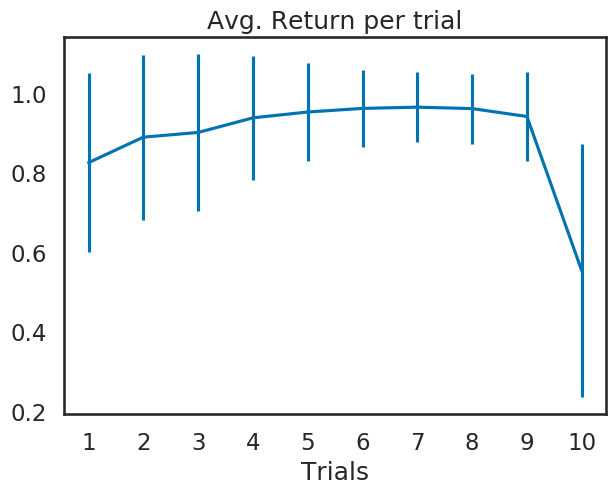

In [95]:
# avg reward across trials
f, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=100)
ax.errorbar(range(1, n_trials+1), rewards.mean(0), yerr=rewards.std(0))
ax.set_title('Avg. Return per trial')
ax.set_xlabel('Trials')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# # avg regret across trials
# ax[1].errorbar(range(1, n_trials+1), regrets.mean(0), yerr=regrets.std(0))
# ax[1].set_title('Avg. Regret per-trial')
# ax[1].set_xlabel('Trials')
# ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
 
# # avg qvalues
# ax[2].plot(Y[0].T, 'k', lw=2, label='True Structure')
# ax[2].errorbar(range(n_arms), values.mean(0).mean(0), yerr=values.mean(1).std(0), label='Predicted Q-values')
# ax[2].set_title('Q-values')
# ax[2].set_xlabel('Arms')
# ax[2].legend(loc='lower right')
# ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

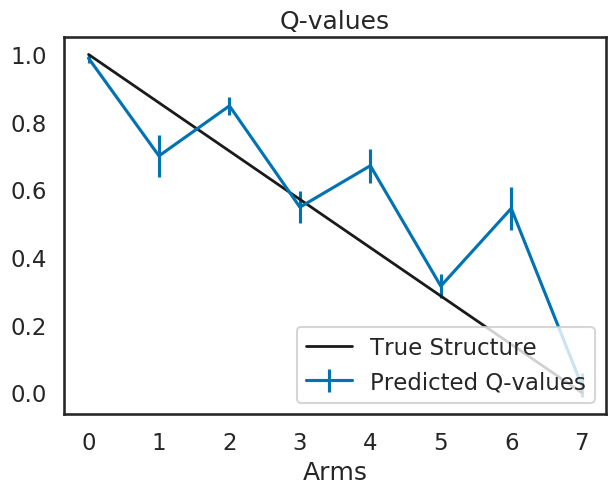

In [96]:
# avg reward across trials
f, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=100)
# ax[0].errorbar(range(1, n_trials+1), rewards.mean(0), yerr=rewards.std(0))
# ax[0].set_title('Avg. Return per trial')
# ax[0].set_xlabel('Trials')
# ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# # avg regret across trials
# ax[1].errorbar(range(1, n_trials+1), regrets.mean(0), yerr=regrets.std(0))
# ax[1].set_title('Avg. Regret per-trial')
# ax[1].set_xlabel('Trials')
# ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
 
# avg qvalues
ax.plot(Y[0].T, 'k', lw=2, label='True Structure')
ax.errorbar(range(n_arms), values.mean(0).mean(0), yerr=values.mean(1).std(0), label='Predicted Q-values')
ax.set_title('Q-values')
ax.set_xlabel('Arms')
ax.legend(loc='lower right')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [97]:
f.savefig('/notebooks/figs/'+'qfunctions'+cue)

In [15]:
def run_model_eval(agent, X, Y, init_at=None):
    
    aa, vv, rr, rs =  [], [], [], []
    
    # run model for n_runs
    agent.eval()
    agent.turn_off_encoding()

    # set init states
    h_t, c_t = agent.get_init_states()
    h_t, c_t = torch.zeros_like(h_t), torch.zeros_like(c_t) 
    r_t = Y[0].mean() 
    a_t = init_at
    
    # run model
    for t in range(total_trials):
        x_t = X[t] 
        trial = t%n_trials
        
        if agent.inputs == 'context_action_reward':
            one_hot_a_t = one_hot_embedding(a_t, n_arms)
            x_t = torch.cat((x_t.type(torch.FloatTensor), one_hot_a_t.reshape(-1).type(torch.FloatTensor), 
                             r_t.reshape(-1).type(torch.FloatTensor), torch.tensor(trial).reshape(-1).type(torch.FloatTensor)), dim=0)
        output_t, c = agent(x_t, h_t, c_t)
        a_t, prob_a_t, v_t, h_t, c_t = output_t
        f_t, i_t, o_t, rg_t, m_t, q_t, pa_t = c

        # bootstrap reward from q-values
        r_t = Y[t][a_t] 

        # predicted q-value
        Q = q_t.detach().numpy().T
        Q = Q - Q.min()
        Q = Q/Q.max()

        # store results
        rs.append(r_t)
        aa.append(a_t) 
        rr.append(Y[t].max() - r_t)
        vv.append(Q)
    
    return torch.stack(aa), torch.stack(rs), torch.stack(rr), np.hstack(vv).T

In [16]:

def one_hot_embedding(arm, num_arms):
    """Embedding labels to one-hot form.

    Args:
      arms: (LongTensor) arms for which embedding is required, sized [N,].
      num_arms: (int) number of arms.

    Returns:
      (tensor) encoded arms, sized [N, #classes].
    """
    y = torch.eye(num_arms) 
    
    return torch.zeros(num_arms) if arm is None else y[arm]
    

In [167]:
CUES

{'linpos': array([1., 0., 0.]),
 'pereven': array([0., 1., 1.]),
 'linneg': array([0., 1., 0.]),
 'perodd': array([1., 0., 1.])}

In [152]:
''' model evaluation for different cues'''

cue = 'pereven'
n_runs = 10
X, Y = task.sample(end_rnd=1, cue=cue)
agent.turn_on_retrieval()

In [159]:
X, Y2 = task.sample(end_rnd=1, cue='linpos')

In [160]:
Y = Y+Y2

In [168]:
CUES_EVAL = CUES

tensor([6]) tensor([2.7143], dtype=torch.float64)


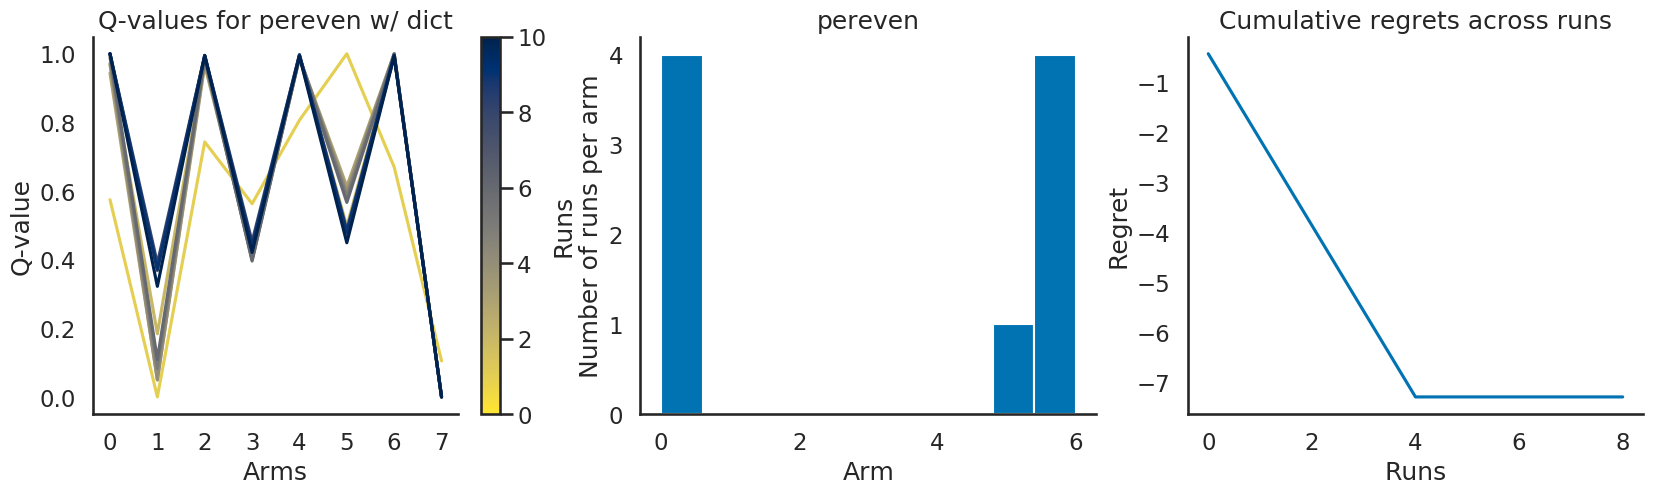

In [169]:
# params
# CUES_EVAL = CUES_EVAL  
# {'periodic': torch.tensor([1., 0.]), 
#  'linear':   torch.tensor([0., 1.]), 
#  'linperiodic': torch.tensor([1.0, 1.0])} 

n_cues = len(CUES_EVAL)
 
# set up the color scheme
c = np.arange(n_runs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# run model for n_runs
agent.eval()
agent.turn_off_encoding()

# set init states
h_t, c_t = agent.get_init_states()
h_t, c_t = torch.zeros_like(h_t), torch.zeros_like(c_t)  
a_t = torch.randint(high=dim_output,size=(1,)) 
r_t = Y[0][a_t] 
 
#a_t = torch.tensor([7]) # torch.randint(high=dim_output,size=(1,))
#r_t = torch.tensor([1.]) # Y[0][a_t] 

print(a_t, r_t)
actions, dist, values, temps = [], [], [], []
f, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

# run model
for t in range(n_runs):
    h_t1 = h_t
    c_t1 = c_t
    #x_t = X[0] # torch.tensor(CUES_EVAL[cue])
    x_t = torch.tensor([1., 1., 1.]) #torch.tensor(CUES_EVAL['linpos'])
    if inputs == 'context_action_reward':
        one_hot_a_t = one_hot_embedding(a_t, n_arms)
        x_t = torch.cat((x_t.type(torch.FloatTensor), one_hot_a_t.reshape(-1).type(torch.FloatTensor), r_t.reshape(-1).type(torch.FloatTensor), torch.tensor(t).reshape(-1).type(torch.FloatTensor)), dim=0)
    output_t, c = agent(x_t, h_t, c_t)
    a_t, prob_a_t, v_t, h_t, c_t = output_t
    f_t, i_t, o_t, rg_t, m_t, q_t, pa_t = c
    a_t = torch.argmax(q_t)
    
    # bootstrap reward from q-values
    r_t = Y[0][a_t]     
    if t>=0:
        Q = q_t.detach().numpy().T
        Q = Q - Q.min()
        Q = Q/Q.max()
        ax[0].plot(Q, c=cmap.to_rgba(t + 1))
    
    
    dist.append(torch.sum(F.pairwise_distance(h_t1, h_t, p=2)))
    actions.append(a_t) 
    temps.append(1. - r_t) 
    # values.append(q_t[0][aoi[cue]]) 
    
# format figure
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set(xlabel='Arms',
       ylabel='Q-value',
      title= 'Q-values for {} w/ dict'.format(cue))
cbar = plt.colorbar(cmap, ticks=np.arange(n_runs+1, step=n_runs/5), ax=ax[0])
cbar.set_label('Runs', rotation=90)

_ = ax[1].hist(actions[:t])
ax[1].set(xlabel='Arm',
       ylabel='Number of runs per arm', title = cue)
ax[2].plot(np.cumsum(torch.stack(temps).cpu().data.numpy())[:t])
ax[2].set(xlabel='Runs',
       ylabel='Regret',
      title='Cumulative regrets across runs')


sns.despine()
plt.show()

In [144]:
actions

[tensor(7), tensor(0), tensor(0), tensor(0)]

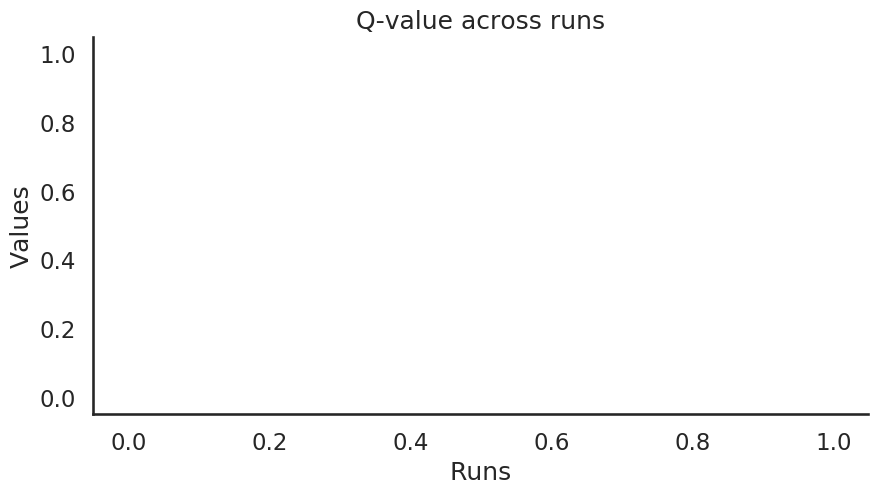

In [28]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.plot(values)
ax.set(xlabel='Runs',
       ylabel='Values',
      title='Q-value across runs')
sns.despine()
plt.show()


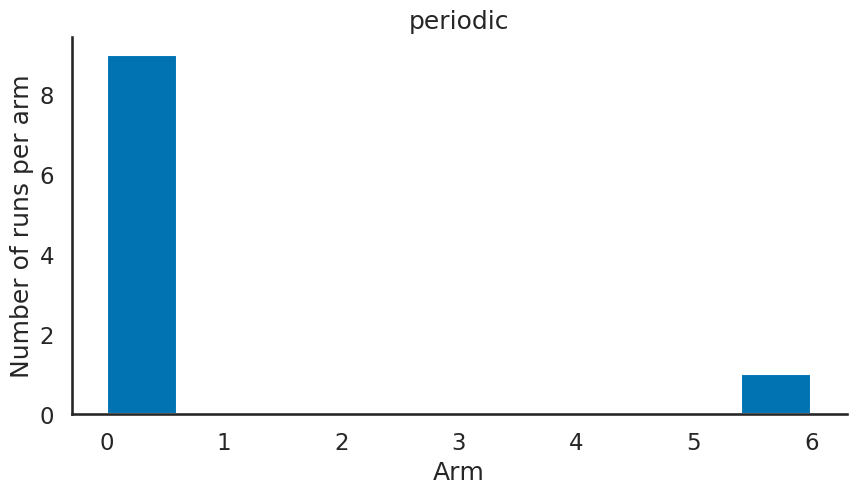

In [86]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
_ = ax.hist(actions)
ax.set(xlabel='Arm',
       ylabel='Number of runs per arm', title = cue)
sns.despine()
plt.show()